# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
# Importamos librerías
import pandas as pd
import pandas_datareader as web
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Función para descargar precios de cierre ajustados de varios activos a la vez:
def get_closes(names,start,end):
    closes = web.DataReader(name=names,data_source="yahoo",start=start,end=end)
    return closes["Adj Close"]   

In [3]:
# Descargamos datos...
# Instrumento: Amazon
name = "RACE"

# Fechas de interés (inicio y fin): 2013-2017
start = "2014-01-01"
end = "2018-12-31"

# Función DataReader
close = get_closes(name,start,end)
close

Date
2015-10-21     52.960567
2015-10-22     54.645676
2015-10-23     54.289398
2015-10-26     52.979824
2015-10-27     51.853207
2015-10-28     49.946629
2015-10-29     49.128151
2015-10-30     48.560024
2015-11-02     51.111763
2015-11-03     50.437721
2015-11-04     51.458412
2015-11-05     49.821453
2015-11-06     50.485863
2015-11-09     51.227318
2015-11-10     51.997650
2015-11-11     52.325035
2015-11-12     52.113194
2015-11-13     49.494061
2015-11-16     47.674137
2015-11-17     47.163792
2015-11-18     45.526825
2015-11-19     45.834961
2015-11-20     46.297169
2015-11-23     44.294292
2015-11-24     44.563911
2015-11-25     43.966904
2015-11-27     44.352070
2015-11-30     44.631313
2015-12-01     45.873482
2015-12-02     45.459423
                 ...    
2018-11-15    110.872139
2018-11-16    109.820938
2018-11-19    107.916870
2018-11-20    104.366577
2018-11-21    105.844223
2018-11-23    105.774803
2018-11-26    108.313553
2018-11-27    103.900482
2018-11-28    107.43

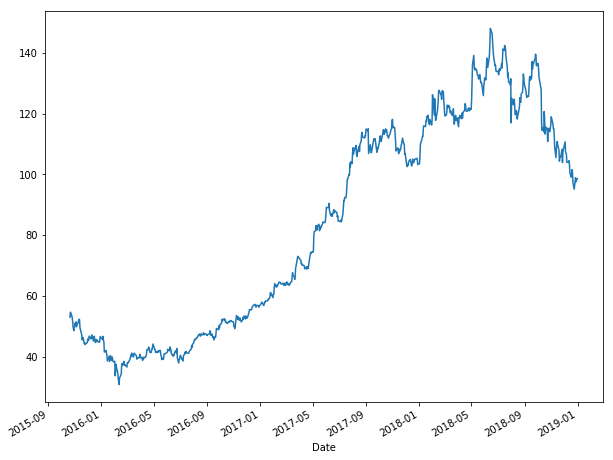

In [4]:
# Graficamos
close.plot(figsize=(10,8));

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

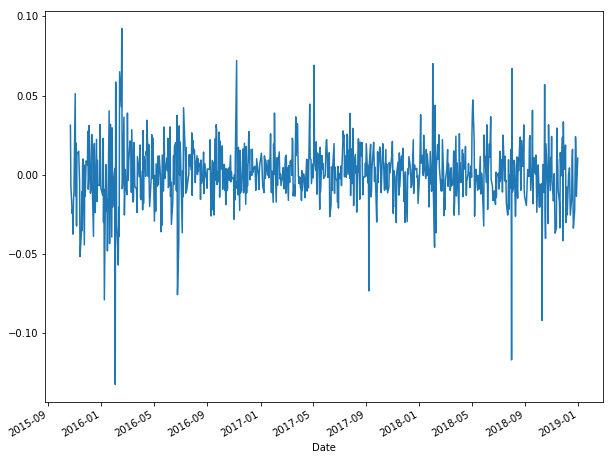

In [8]:
# Calcular a diferencia logarítmica de precios y graficarlos
ret = np.log(close/close.shift()).dropna()
ret.plot(figsize=(10,8));

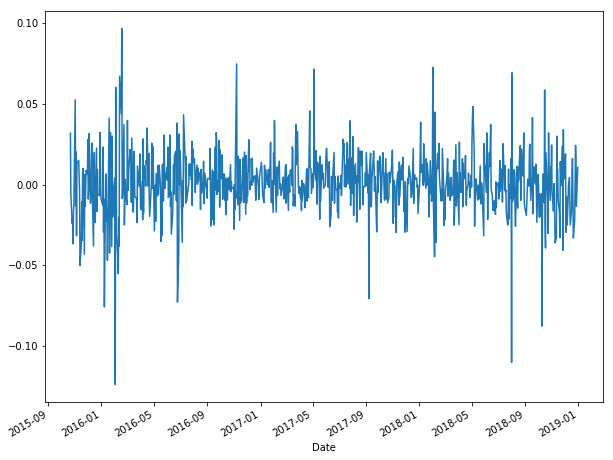

In [9]:
# Calcular rendimientos diarios y graficarlos
ret = close.pct_change().dropna()
ret.plot(figsize=(10,8));

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [10]:
# Calculamos media y desviación estándar
mu = ret.mean()
sigma = ret.std()
mu,sigma

(0.0009665274714593435, 0.019553134383401158)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2017, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2018 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [11]:
# Ayuda en la función np.random.randn
help(np.random.randn)

Help on built-in function randn:

randn(...) method of mtrand.RandomState instance
    randn(d0, d1, ..., dn)
    
    Return a sample (or samples) from the "standard normal" distribution.
    
    If positive, int_like or int-convertible arguments are provided,
    `randn` generates an array of shape ``(d0, d1, ..., dn)``, filled
    with random floats sampled from a univariate "normal" (Gaussian)
    distribution of mean 0 and variance 1 (if any of the :math:`d_i` are
    floats, they are first converted to integers by truncation). A single
    float randomly sampled from the distribution is returned if no
    argument is provided.
    
    This is a convenience function.  If you want an interface that takes a
    tuple as the first argument, use `numpy.random.standard_normal` instead.
    
    Parameters
    ----------
    d0, d1, ..., dn : int, optional
        The dimensions of the returned array, should be all positive.
        If no argument is given a single Python float is ret

In [12]:
# Función que simula varios escenarios de rendimientos diarios
def ret_sim(mu,sigma,ndays,nscen,start_date):
    dates = pd.date_range(start = start_date,periods=ndays)
    rend_sim = sigma*np.random.randn(ndays,nscen) + mu
    return pd.DataFrame(index = dates, data = rend_sim)

In [13]:
# Simulamos 100 escenarios para todo el 2019
rend_sim = ret_sim(mu,sigma,365,100,"2019-01-01")
rend_sim

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2019-01-01,0.011582,-0.017867,-0.003925,0.010327,0.028545,-0.029727,-0.001383,-0.003666,-0.027672,0.010114,...,-0.011971,-0.012202,0.001493,0.001834,-0.007970,0.001976,0.019584,0.021895,0.001509,0.015249
2019-01-02,-0.037414,0.014023,0.010148,-0.015949,-0.027334,0.010181,0.015420,0.015883,-0.020721,-0.016975,...,0.022363,0.013696,-0.001788,0.037809,0.016212,0.030435,0.021494,-0.001090,-0.035382,0.013019
2019-01-03,0.005780,0.007607,0.023748,-0.009338,-0.022166,-0.030636,-0.002788,-0.018344,0.001838,-0.010723,...,0.006120,0.016630,0.008619,0.022812,0.023463,-0.009395,0.001403,0.020813,0.007474,0.018852
2019-01-04,0.026163,0.018696,0.001424,0.035449,0.038624,-0.001813,0.016027,-0.022467,0.002120,-0.015868,...,-0.006388,-0.015860,0.003915,-0.013485,0.005298,-0.000154,0.003102,0.010596,-0.002235,-0.021694
2019-01-05,0.027104,-0.015531,0.005216,0.001503,0.065394,0.017760,0.009377,0.014705,0.020002,-0.005785,...,0.002823,0.014203,-0.015311,-0.003588,0.036308,-0.026821,-0.000290,-0.002581,0.018935,-0.019519
2019-01-06,0.023279,-0.020028,0.022829,0.011327,0.009535,0.011497,0.005241,-0.016148,-0.028444,-0.042354,...,0.009253,-0.022145,-0.003270,0.025441,-0.025091,0.003598,0.012298,-0.004900,0.005691,-0.014854
2019-01-07,-0.003287,-0.009916,0.005165,-0.009463,-0.010110,-0.022402,-0.005464,-0.025002,0.003499,-0.006199,...,-0.000642,0.013896,0.012057,-0.008632,-0.015335,-0.028277,0.012218,-0.008733,0.002139,-0.000654
2019-01-08,0.024113,-0.026013,-0.019333,-0.005640,0.039845,0.019997,0.030566,0.025013,-0.003442,-0.017658,...,0.027863,-0.009824,0.014717,-0.010264,-0.043327,0.013829,0.034900,0.036108,-0.017149,0.003881
2019-01-09,0.048711,0.000848,-0.036432,0.047376,-0.006589,-0.029271,-0.016731,0.010967,-0.027139,-0.004659,...,-0.032298,-0.009921,0.029646,-0.008944,0.007900,-0.021232,0.023967,0.007088,0.006185,0.004249
2019-01-10,-0.009152,-0.013676,-0.002997,-0.011132,-0.002837,-0.002250,0.002666,0.014211,-0.000678,-0.006026,...,-0.018035,0.019606,-0.012057,0.000687,0.006295,0.006836,-0.028799,-0.027829,0.042481,0.004422


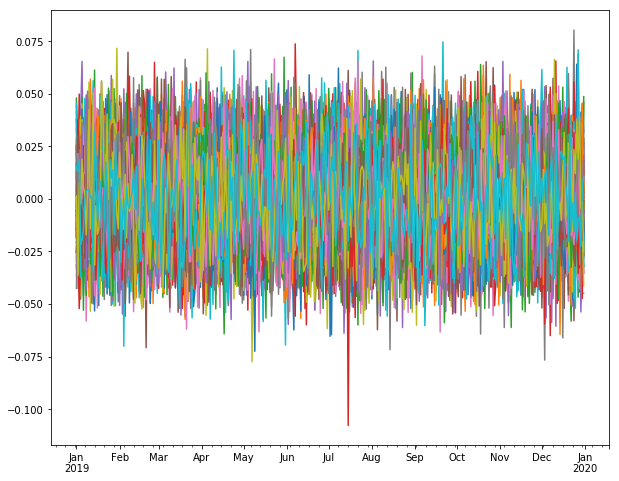

In [14]:
# Mostrar
rend_sim.plot(figsize=(10,8),legend=False);

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2017.

Con los rendimientos, calculamos los precios de cierre...

In [15]:
# Obtenemos los precios
simcloses = close.iloc[-1]*((1+rend_sim).cumprod())
simcloses

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2019-01-01,99.756924,96.852764,98.227616,99.633157,101.429664,95.683159,98.478291,98.253204,95.885830,99.612159,...,97.434161,97.411392,98.761977,98.795544,97.828783,98.809609,100.545981,100.773856,98.763500,100.118547
2019-01-02,96.024575,98.210951,99.224393,98.044148,98.657161,96.657287,99.996854,99.813760,93.898959,97.921285,...,99.613072,98.745506,98.585429,102.530941,99.414769,101.816833,102.707165,100.664025,95.269008,101.422032
2019-01-03,96.579585,98.958032,101.580769,97.128617,96.470293,93.696096,99.718045,97.982768,94.071554,96.871293,...,100.222702,100.387685,99.435147,104.869854,101.747316,100.860287,102.851258,102.759100,95.981063,103.334076
2019-01-04,99.106380,100.808159,101.725405,100.571765,100.196389,93.526241,101.316205,95.781353,94.270994,95.334157,...,99.582518,98.795582,99.824426,103.455734,102.286420,100.844788,103.170275,103.847891,95.766502,101.092325
2019-01-05,101.792572,99.242511,102.255976,100.722905,106.748645,95.187254,102.266234,97.189835,96.156612,94.782606,...,99.863655,100.198798,98.295993,103.084564,106.000234,98.140072,103.140337,103.579838,97.579831,99.119113
2019-01-06,104.162239,97.254874,104.590352,101.863785,107.766521,96.281633,102.802210,95.620377,93.421580,90.768192,...,100.787725,97.979873,97.974518,105.707129,103.340606,98.493207,104.408806,103.072279,98.135201,97.646823
2019-01-07,103.819829,96.290481,105.130552,100.899850,106.677012,94.124709,102.240456,93.229724,93.748461,90.205560,...,100.723031,99.341443,99.155803,104.794641,101.755854,95.708106,105.684443,102.172126,98.345159,97.582983
2019-01-08,106.323286,93.785715,103.098075,100.330753,110.927593,96.006904,105.365530,95.561642,93.425793,88.612744,...,103.529527,98.365503,100.615112,103.719012,97.347045,97.031660,109.372780,105.861375,96.658650,97.961722
2019-01-09,111.502350,93.865251,99.341981,105.084024,110.196725,93.196693,103.602695,96.609637,90.890324,88.199909,...,100.185740,97.389634,103.597944,102.791309,98.116084,94.971507,111.994168,106.611682,97.256471,98.378008
2019-01-10,110.481827,92.581506,99.044291,103.914188,109.884124,92.987007,103.878897,97.982590,90.828661,87.668460,...,98.378902,99.299094,102.348812,102.861976,98.733713,95.620699,108.768881,103.644832,101.387983,98.812990


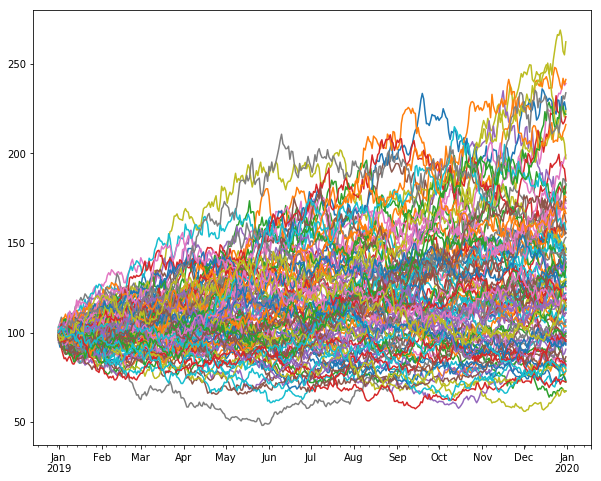

In [18]:
# Graficar
simcloses.plot(figsize=(10,8),legend=False);

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [ ]:
# Umbral de 110% del ultimo precio


# Fechas

# DataFrame de Umbrales

# Concatenar y graficar


In [ ]:
# Comparar cada escenario en cada fecha

# Sumamos para cada fecha y dividimos entre el número de escenarios

# Gráfico de probabilidad


___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Cristian Camilo Zapata Zuluaga.
</footer>